In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.metrics import error_rate, accuracy
from torchvision.transforms import RandAugment
from torchvision.models.efficientnet import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import shutil
import hashlib
import os
import timm
import seaborn as sns
import cv2
import imagehash
from pathlib import Path
import warnings
import gc
import torch
from torch.utils.data import WeightedRandomSampler

warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
base_path = Path("/kaggle/input")
train_path = base_path/'Train'/'Train'
test_path = base_path/'Test'/'Test'
base_path.ls()

train_cleaned_path = Path('/kaggle/working/train_cleaned/')

if not train_cleaned_path.exists():
    print(f"Copying '{train_cleaned_path}'...")
    shutil.copytree(train_path, train_cleaned_path)
    print("Success")
else:
    print(f"'{train_cleaned_path}' already exist")

Copying '/kaggle/working/train_cleaned'...
Success


In [3]:
move_map = {
    'balinese_train_000003.jpg': 'javanese',
    'balinese_train_000066.jpg': 'javanese',
    # 'balinese_train_000157.jpg': 'delete',
    'balinese_train_000083.jpg': 'batak',
    # 'balinese_train_000192.jpg': 'delete',
    # 'balinese_train_000233.jpg': 'delete',
    'balinese_train_000245.jpg': 'minangkabau',
    'balinese_train_000278.jpg': 'javanese',
    # 'balinese_train_000341.jpg': 'delete',
    # 'balinese_train_000391.jpg': 'delete',
    # 'balinese_train_000425.jpg': 'delete',
    # 'balinese_train_000489.jpg': 'delete',
    'balinese_train_000529.jpg': 'javanese',
    # 'balinese_train_000559.jpg': 'delete',
    'balinese_train_000586.jpg': 'javanese',
    'balinese_train_000595.jpg': 'dayak',
    'balinese_train_000651.jpg': 'javanese',
    # 'balinese_train_000721.jpg': 'delete',
    # 'balinese_train_000740.jpg': 'delete',
    'balinese_train_000745.jpg': 'javanese',
    'balinese_train_000760.jpg': 'batak',
    'balinese_train_000761.jpg': 'batak',
    'balinese_train_000762.jpg': 'batak',
    'balinese_train_000763.jpg': 'dayak',
    'balinese_train_000764.jpg': 'minangkabau',
    'balinese_train_000765.jpg': 'javanese',
    'balinese_train_000766.jpg': 'javanese',
    'balinese_train_000767.jpg': 'javanese',
    'balinese_train_000768.jpg': 'javanese',
    'balinese_train_000769.jpg': 'javanese',
    'balinese_train_000770.jpg': 'javanese',
    'balinese_train_000771.jpg': 'minangkabau',
    'balinese_train_000772.jpg': 'minangkabau',
    'balinese_train_000773.jpg': 'minangkabau',
    'balinese_train_000774.jpg': 'minangkabau',
    # 'balinese_train_000775.jpg': 'delete',
    'balinese_train_000776.jpg': 'minangkabau',
    'batak_train_000001.jpg': 'balinese',
    'batak_train_000002.jpg': 'balinese',
    # 'batak_train_000003.jpg': 'delete',
    # 'batak_train_000004.jpg': 'delete',
    'batak_train_000007.jpg': 'balinese',
    'batak_train_000010.jpg': 'javanese',
    'batak_train_000023.jpg': 'minangkabau',
    # 'batak_train_000032.jpg': 'delete',
    # 'batak_train_000033.jpg': 'delete',
    # 'batak_train_000035.jpg': 'delete',
    # 'batak_train_000038.jpg': 'delete',
    # 'batak_train_000040.jpg': 'delete',
    # 'batak_train_000042.jpg': 'delete',
    # 'batak_train_000043.jpg': 'delete',
    # 'batak_train_000057.jpg': 'delete',
    'batak_train_000056.jpg': 'minangkabau',
    'batak_train_000059.jpg': 'minangkabau',
    'batak_train_000062.jpg': 'minangkabau',
    'batak_train_000067.jpg': 'minangkabau',
    'batak_train_000071.jpg': 'balinese',
    # 'batak_train_000072.jpg': 'delete',
    'batak_train_000086.jpg': 'balinese',
    'batak_train_000091.jpg': 'dayak',
    'batak_train_000092.jpg': 'javanese',
    'batak_train_000093.jpg': 'javanese',
    'batak_train_000094.jpg': 'minangkabau',
    'batak_train_000095.jpg': 'minangkabau',
    'dayak_train_000004.jpg': 'minangkabau',
    'dayak_train_000019.jpg': 'balinese',
    # 'dayak_train_000025.jpg': 'delete',
    'dayak_train_000026.jpg': 'minangkabau',
    'dayak_train_000052.jpg': 'javanese',
    'javanese_train_000007.jpg': 'balinese',
    'javanese_train_000009.jpg': 'balinese',
    'javanese_train_000012.jpg': 'batak',
    'javanese_train_000015.jpg': 'dayak',
    'javanese_train_000025.jpg': 'balinese',
    'javanese_train_000024.jpg': 'balinese',
    'javanese_train_000032.jpg': 'balinese',
    'javanese_train_000041.jpg': 'balinese',
    'javanese_train_000050.jpg': 'balinese',
    # 'javanese_train_000055.jpg': 'delete',
    'javanese_train_000077.jpg': 'balinese',
    'javanese_train_000099.jpg': 'balinese',
    'javanese_train_000111.jpg': 'batak',
    'javanese_train_000122.jpg': 'balinese',
    'javanese_train_000152.jpg': 'balinese',
    'javanese_train_000158.jpg': 'balinese',
    'javanese_train_000169.jpg': 'balinese',
    'javanese_train_000202.jpg': 'balinese',
    'javanese_train_000213.jpg': 'batak',
    'javanese_train_000245.jpg': 'minangkabau',
    'javanese_train_000246.jpg': 'minangkabau',
    'javanese_train_000247.jpg': 'minangkabau',
    'javanese_train_000248.jpg': 'minangkabau',
    'javanese_train_000249.jpg': 'minangkabau',
    'minangkabau_train_000003.jpg': 'balinese',
    'minangkabau_train_000005.jpg': 'balinese',
    'minangkabau_train_000008.jpg': 'balinese',
    'minangkabau_train_000117.jpg': 'balinese',
    'minangkabau_train_000186.jpg': 'balinese',
    'minangkabau_train_000299.jpg': 'balinese',
    'minangkabau_train_000013.jpg': 'javanese',
    'minangkabau_train_000017.jpg': 'javanese',
    'minangkabau_train_000021.jpg': 'javanese',
    'minangkabau_train_000106.jpg': 'javanese',
    'minangkabau_train_000129.jpg': 'javanese',
    'minangkabau_train_000170.jpg': 'javanese',
    'minangkabau_train_000180.jpg': 'javanese',
    'minangkabau_train_000200.jpg': 'javanese',
    'minangkabau_train_000225.jpg': 'javanese',
    'minangkabau_train_000341.jpg': 'javanese',
    'minangkabau_train_000394.jpg': 'javanese',
    'minangkabau_train_000414.jpg': 'javanese',
    'minangkabau_train_000416.jpg': 'javanese',
    'minangkabau_train_000438.jpg': 'javanese',
    'minangkabau_train_000459.jpg': 'javanese',
    'minangkabau_train_000498.jpg': 'javanese',
    'minangkabau_train_000523.jpg': 'javanese',
    'minangkabau_train_000543.jpg': 'javanese',
    'minangkabau_train_000559.jpg': 'javanese',
    'minangkabau_train_000015.jpg': 'dayak',
    'minangkabau_train_000125.jpg': 'dayak',
    'minangkabau_train_000012.jpg': 'batak',
    'minangkabau_train_000313.jpg': 'batak',
    'minangkabau_train_000411.jpg': 'batak',
    # 'minangkabau_train_000006.jpg': 'delete',
    'minangkabau_train_000010.jpg': 'balinese'
    # 'minangkabau_train_000014.jpg': 'delete',
    # 'minangkabau_train_000042.jpg': 'delete',
    # 'minangkabau_train_000080.jpg': 'delete',
    # 'minangkabau_train_000114.jpg': 'delete',
    # 'minangkabau_train_000128.jpg': 'delete',
    # 'minangkabau_train_000141.jpg': 'delete',
    # 'minangkabau_train_000151.jpg': 'delete',
    # 'minangkabau_train_000154.jpg': 'delete',
    # 'minangkabau_train_000194.jpg': 'delete',
    # 'minangkabau_train_000216.jpg': 'delete',
    # 'minangkabau_train_000258.jpg': 'delete',
    # 'minangkabau_train_000259.jpg': 'delete',
    # 'minangkabau_train_000286.jpg': 'delete',
    # 'minangkabau_train_000301.jpg': 'delete',
    # 'minangkabau_train_000316.jpg': 'delete',
    # 'minangkabau_train_000320.jpg': 'delete',
    # 'minangkabau_train_000378.jpg': 'delete',
    # 'minangkabau_train_000429.jpg': 'delete',
    # 'minangkabau_train_000497.jpg': 'delete',
    # 'minangkabau_train_000506.jpg': 'delete',
    # 'minangkabau_train_000510.jpg': 'delete',
    # 'minangkabau_train_000540.jpg': 'delete'
}

phash_threshold = 7

def file_md5(path):
    with open(path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def perceptual_hash(path):
    try:
        return imagehash.phash(Image.open(path))
    except Exception as e:
        print(f"Error hashing {path}: {e}")
        return None

def find_duplicates(root_dir, phash_threshold=5):
    files_info = {}
    clusters = []
    visited = set()

    for subdir, _, files in os.walk(root_dir):
        for f in files:
            if not f.lower().endswith(('.jpg','.jpeg','.png')):
                continue
            path = os.path.join(subdir, f)
            h_md5 = file_md5(path)
            h_phash = perceptual_hash(path)
            files_info[f] = (path, h_md5, h_phash)

    md5_groups = defaultdict(list)
    for fname, (path, h_md5, h_phash) in files_info.items():
        md5_groups[h_md5].append(fname)

    for group in md5_groups.values():
        if len(group) > 1:
            clusters.append(set(group))
            visited.update(group)

    names = list(files_info.keys())
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            f1, f2 = names[i], names[j]
            if f1 in visited and f2 in visited:
                continue
            h1 = files_info[f1][2]
            h2 = files_info[f2][2]
            if h1 is None or h2 is None:
                continue
            if h1 - h2 <= phash_threshold:
                clusters.append({f1,f2})
                visited.update([f1,f2])

    return clusters, files_info

def update_move_map_with_clusters(clusters, move_map):
    new_map = move_map.copy()

    for cluster in clusters:
        existing_labels = {f:new_map[f] for f in cluster if f in new_map}
        if existing_labels:
            correct_label = list(existing_labels.values())[0]
            for f in cluster:
                new_map[f] = correct_label
    return new_map

def execute_move_map(move_map, files_info, root_dir):
    for f, target in move_map.items():
        if f not in files_info:
            continue
        src_path = files_info[f][0]
        if target == "delete":
            os.remove(src_path)
            print(f"Deleted {f}")
        else:
            dst_dir = os.path.join(root_dir, target)
            os.makedirs(dst_dir, exist_ok=True)
            dst_path = os.path.join(dst_dir, f)
            if src_path != dst_path:
                shutil.move(src_path, dst_path)
                print(f"Moved {f} -> {target}")

def cleanup_duplicates(clusters, files_info):
    for cluster in clusters:
        keep = list(cluster)[0]
        for f in cluster:
            if f == keep: continue
            path = files_info[f][0]
            if os.path.exists(path):
                os.remove(path)
                print(f"Removed duplicate {f}, kept {keep}")


clusters, files_info = find_duplicates(train_cleaned_path, phash_threshold)
print(f"Found {len(clusters)} duplicate clusters")
new_move_map = update_move_map_with_clusters(clusters, move_map)
print(f"Updated move_map size: {len(new_move_map)}")

execute_move_map(new_move_map, files_info, train_cleaned_path)
cleanup_duplicates(clusters, files_info)
print("Dataset cleaning finished ✅")

Found 76 duplicate clusters
Updated move_map size: 137
Moved balinese_train_000003.jpg -> javanese
Moved balinese_train_000066.jpg -> javanese
Moved balinese_train_000083.jpg -> batak
Moved balinese_train_000245.jpg -> minangkabau
Moved balinese_train_000278.jpg -> javanese
Moved balinese_train_000529.jpg -> javanese
Moved balinese_train_000586.jpg -> javanese
Moved balinese_train_000595.jpg -> dayak
Moved balinese_train_000651.jpg -> javanese
Moved balinese_train_000745.jpg -> javanese
Moved balinese_train_000760.jpg -> batak
Moved balinese_train_000761.jpg -> batak
Moved balinese_train_000762.jpg -> batak
Moved balinese_train_000763.jpg -> dayak
Moved balinese_train_000764.jpg -> minangkabau
Moved balinese_train_000765.jpg -> javanese
Moved balinese_train_000766.jpg -> javanese
Moved balinese_train_000767.jpg -> javanese
Moved balinese_train_000768.jpg -> javanese
Moved balinese_train_000769.jpg -> javanese
Moved balinese_train_000770.jpg -> javanese
Moved balinese_train_000771.jpg -

In [4]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

aug = A.Compose
([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.15,
        rotate_limit=25,
        p=0.8
    ),
    A.OneOf([
        A.OpticalDistortion(distort_limit=0.2, p=1.0),
        A.GridDistortion(p=1.0),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
    ], p=0.3),
    A.OneOf([
        A.RandomRain(brightness_coefficient=0.8, drop_width=1, blur_value=3, p=1.0),
        A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=0.5, p=1.0),
        A.RandomSunFlare(p=1.0)
    ], p=0.2),
    A.RandomBrightnessContrast(p=0.8),
    A.HueSaturationValue(
        hue_shift_limit=15,
        sat_shift_limit=25,
        val_shift_limit=15,
        p=0.5
    ),
    A.Solarize(p=0.1),
    A.OneOf([
        A.GaussianBlur(p=1.0),
        A.MotionBlur(p=1.0),
    ], p=0.2),
    A.GridDropout(ratio=0.5, p=0.3)
])

[HorizontalFlip(p=0.5),
 ShiftScaleRotate(p=0.8, shift_limit_x=(-0.1, 0.1), shift_limit_y=(-0.1, 0.1), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-25.0, 25.0), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0),
 OneOf([
   OpticalDistortion(p=1.0, border_mode=0, distort_limit=(-0.2, 0.2), fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, mode='camera'),
   GridDistortion(p=1.0, border_mode=0, distort_limit=(-0.3, 0.3), fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, normalized=True, num_steps=5),
   ElasticTransform(p=1.0, alpha=1.0, approximate=False, border_mode=0, fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, noise_distribution='gaussian', same_dxdy=False, sigma=50.0),
 ], p=0.3),
 OneOf([
   RandomRain(p=1.0, blur_value=3, brightness_coefficient=0.8, 

In [5]:
train_path = train_cleaned_path

In [6]:
def create_dls_with_oversampling(
    train_path, 
    img_size, 
    aug,
    minority_classes=['batak', 'dayak'], 
    oversample_factor=3.0
):
    dls = ImageDataLoaders.from_folder(
        train_path,
        valid_pct=0.2,
        seed=42,
        bs=8,
        item_tfms=RandomResizedCrop(img_size, min_scale=0.75),
        batch_tfms=AlbumentationsTransform(aug)
    )
    
    train_ds = dls.train_ds
    labels = np.array([
        train_ds.vocab.o2i[path.parent.name]
        for path in train_ds.items
    ])

    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    for cls in minority_classes:
        if cls in train_ds.vocab.o2i:
            idx = train_ds.vocab.o2i[cls]
            class_weights[idx] *= oversample_factor
        else:
            print(f"class '{cls}' not found")

    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        sample_weights, 
        num_samples=len(sample_weights),
        replacement=True
    )
    
    dls.train = dls.train.new(
        shuffle=False,
        sampler=sampler
    )

    print(f"Class of {' and '.join(minority_classes)} oversampled | Size: {img_size} | Factor: {oversample_factor}")
    return dls
    
dls_384 = create_dls_with_oversampling(train_path, 384, aug)
dls_480 = create_dls_with_oversampling(train_path, 480, aug)
dls_576 = create_dls_with_oversampling(train_path, 576, aug)

learn = vision_learner(
    dls_384,
    'tf_efficientnetv2_m.in21k',
    metrics = F1Score(average='macro'),
    loss_func = LabelSmoothingCrossEntropy(),
    path = '/kaggle/working/',
    opt_func = ranger
).to_fp16()

Class of batak and dayak oversampled | Size: 384 | Factor: 3.0
Class of batak and dayak oversampled | Size: 480 | Factor: 3.0
Class of batak and dayak oversampled | Size: 576 | Factor: 3.0


model.safetensors:   0%|          | 0.00/325M [00:00<?, ?B/s]

In [7]:
test_files = get_image_files(test_path)
test_dl = dls_480.test_dl(test_files)

print("Classes:", dls_480.vocab)
print("Number of classes:", len(dls_480.vocab))
print("Number of training images:", len(dls_480.train_ds))
print("Number of validation images:", len(dls_480.valid_ds))

Classes: ['balinese', 'batak', 'dayak', 'javanese', 'minangkabau']
Number of classes: 5
Number of training images: 1357
Number of validation images: 339


learning rate optimal: (0.003076096810400486, 3.564511416698224e-06, 0.005649369675666094, 0.12473835051059723)


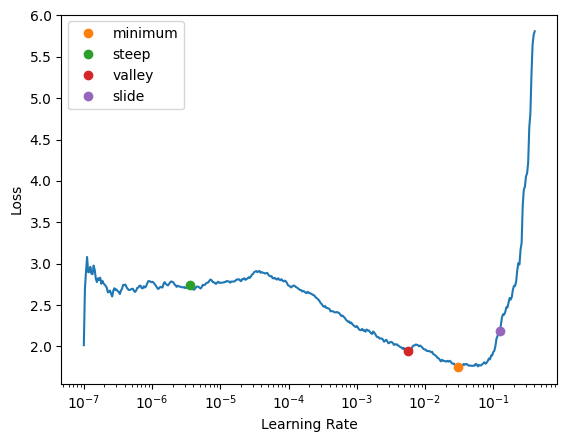

In [8]:
lrs_384 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), num_it = 500)
print(f'learning rate optimal: {lrs_384.minimum, lrs_384.steep, lrs_384.valley, lrs_384.slide}')

In [9]:
learn.fit_one_cycle(
    10, 
    lrs_384.valley,
    cbs = [
        CutMix(),
        SaveModelCallback(monitor='f1_score'),
        EarlyStoppingCallback(monitor='f1_score', patience=5)
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,2.283992,1.287988,0.460356,02:50
1,1.787916,1.116192,0.504328,02:49
2,1.429692,0.901528,0.607043,02:49
3,1.255804,0.817608,0.695006,02:49
4,1.177451,0.827432,0.617341,02:49
5,1.120757,0.753191,0.764042,02:49
6,1.083878,0.796452,0.679066,02:48
7,1.028741,0.760306,0.721026,02:48
8,0.988476,0.751250,0.723947,02:48
9,0.998435,0.751138,0.770418,02:49


Better model found at epoch 0 with f1_score value: 0.4603561535833733.
Better model found at epoch 1 with f1_score value: 0.504327901424474.
Better model found at epoch 2 with f1_score value: 0.6070427545899244.
Better model found at epoch 3 with f1_score value: 0.6950063548427783.
Better model found at epoch 5 with f1_score value: 0.7640417940876657.
Better model found at epoch 9 with f1_score value: 0.7704180534734196.


In [10]:
torch.cuda.empty_cache()
gc.collect()

14988

learning rate optimal: (0.00036307806149125097, 0.1116863265633583, 0.0019408859079703689, 0.05546257272362709)


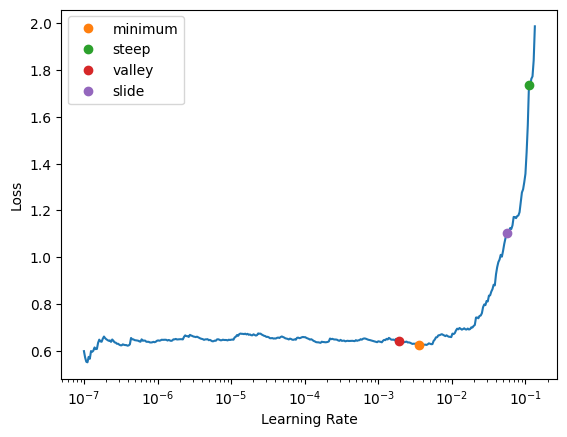

In [11]:
learn.dls = dls_480
lrs_480 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), num_it = 500)
print(f'learning rate optimal: {lrs_480.minimum, lrs_480.steep, lrs_480.valley, lrs_480.slide}')

In [12]:
learn.unfreeze()

learn.fit_one_cycle(
    40,
    lrs_480.minimum/10,
    cbs = [
        CutMix(),
        SaveModelCallback(monitor='f1_score'),
        EarlyStoppingCallback(monitor='f1_score', patience=5)
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,1.024702,0.754872,0.752717,02:24
1,0.998222,0.748484,0.751858,02:27
2,0.973636,0.744621,0.734600,02:26
3,0.972774,0.741380,0.771343,02:25
4,0.992816,0.733965,0.794303,02:25
5,0.963584,0.729939,0.761480,02:25
6,0.956242,0.721964,0.794568,02:26
7,0.963369,0.714743,0.797891,02:24
8,0.942739,0.709251,0.799892,02:26
9,0.940593,0.712106,0.804541,02:25


Better model found at epoch 0 with f1_score value: 0.7527171395807798.
Better model found at epoch 3 with f1_score value: 0.7713426808193995.
Better model found at epoch 4 with f1_score value: 0.794302557041281.
Better model found at epoch 6 with f1_score value: 0.7945684184393862.
Better model found at epoch 7 with f1_score value: 0.7978910117975218.
Better model found at epoch 8 with f1_score value: 0.7998923853649237.
Better model found at epoch 9 with f1_score value: 0.8045408660799638.
Better model found at epoch 11 with f1_score value: 0.8184804032333386.
Better model found at epoch 16 with f1_score value: 0.8334121355397951.
No improvement since epoch 16: early stopping


In [13]:
torch.cuda.empty_cache()
gc.collect()

15753

learning rate optimal: (1.97696965187788e-05, 0.03698281943798065, 0.000237684027524665, 0.02290867641568184)


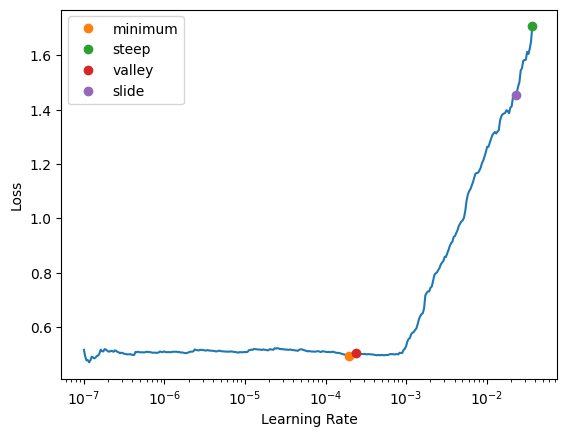

In [14]:
learn.dls = dls_576
lrs_576 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), num_it = 500)
print(f'learning rate optimal: {lrs_576.minimum, lrs_576.steep, lrs_576.valley, lrs_576.slide}')

In [15]:
learn.unfreeze()

learn.fit_one_cycle(
    20,
    lrs_576.minimum/10,
    cbs = [
        CutMix(), 
        SaveModelCallback(monitor='f1_score'),
        EarlyStoppingCallback(monitor='f1_score', patience=5)
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,0.851944,0.689972,0.832844,02:32
1,0.886470,0.689339,0.832844,02:31
2,0.913268,0.691804,0.832844,02:32
3,0.909206,0.687035,0.835979,02:31
4,0.899209,0.684390,0.827161,02:32
5,0.864789,0.689925,0.835979,02:33
6,0.871899,0.688311,0.828103,02:31
7,0.886643,0.689338,0.828103,02:32
8,0.870064,0.688998,0.835979,02:32


Better model found at epoch 0 with f1_score value: 0.832843574210173.
Better model found at epoch 3 with f1_score value: 0.8359790595037625.
No improvement since epoch 3: early stopping


In [16]:
torch.cuda.empty_cache()
gc.collect()

15336

              precision    recall  f1-score   support

    balinese       0.91      0.97      0.94       160
       batak       0.75      0.60      0.67        10
       dayak       1.00      0.75      0.86        12
    javanese       0.88      0.76      0.82        50
 minangkabau       0.90      0.91      0.90       107

    accuracy                           0.90       339
   macro avg       0.89      0.80      0.84       339
weighted avg       0.90      0.90      0.90       339



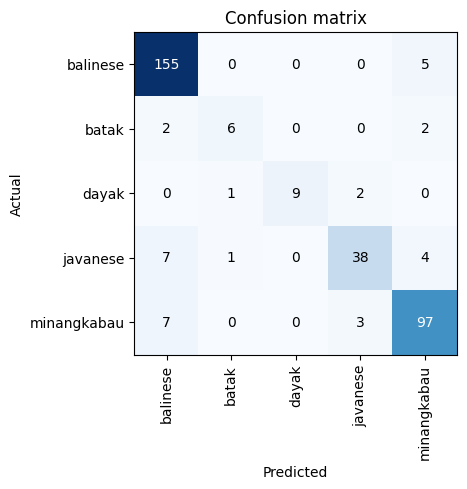

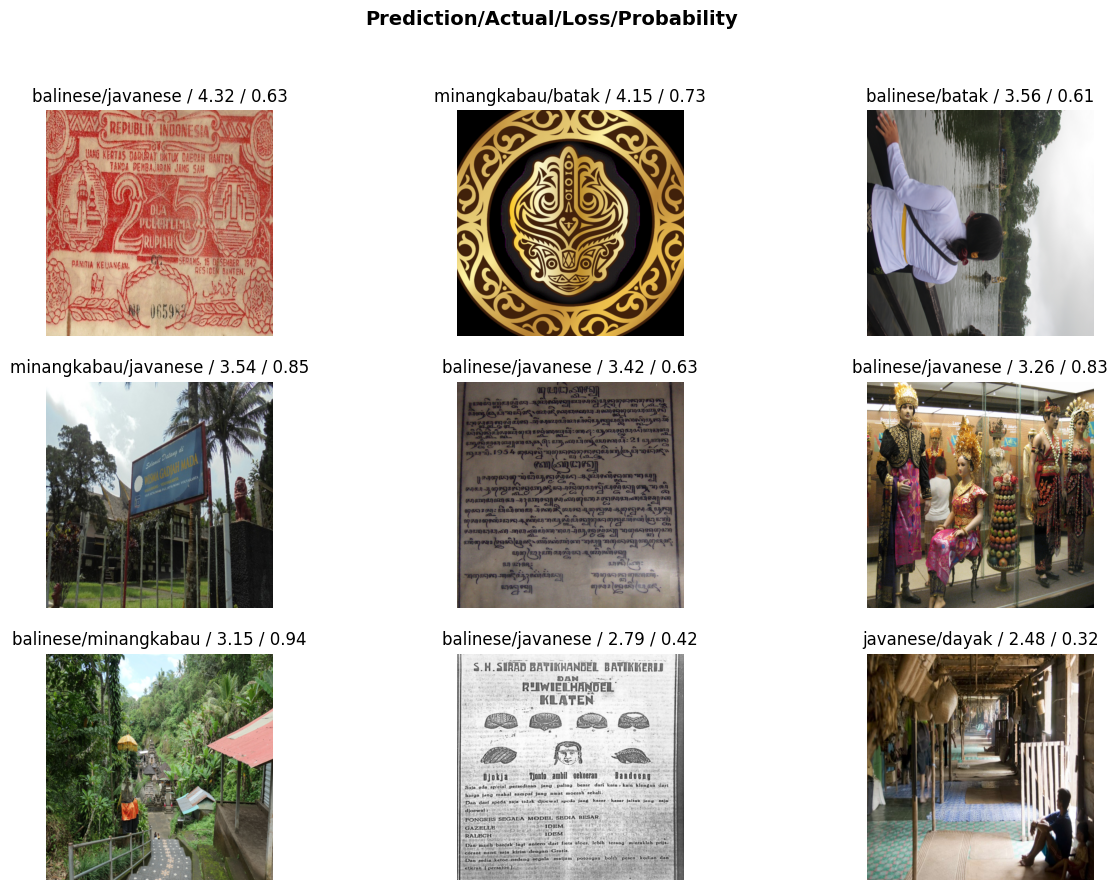

In [17]:
try: 
    interp = ClassificationInterpretation.from_learner(learn, )
    interp.plot_confusion_matrix()
    interp.plot_top_losses(9, figsize=(15,10))
    interp.print_classification_report()
except (AttributeError, NameError) as e:
    print(e)
    pass

In [18]:
nama_file_model = 'klasifikasi-rumah-adat-v1.pkl'
learn.export(nama_file_model)

print(f"Model berhasil disimpan sebagai '{nama_file_model}'!")

Model berhasil disimpan sebagai 'klasifikasi-rumah-adat-v1.pkl'!


In [19]:
test_files = get_image_files(test_path)
preds, _ = learn.get_preds(dl=dls_480.test_dl(test_files))
pred_labels = preds.argmax(dim=1)
label_names = [dls_480.vocab[i] for i in pred_labels]

In [20]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission_get_preds = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission_get_preds = submission_get_preds.set_index('id').loc[sample_sub['id']].reset_index()

submission_get_preds.sort_values('id', inplace = True)
submission_get_preds['style'].value_counts()

style
balinese       205
minangkabau    155
javanese        55
batak           21
dayak            8
Name: count, dtype: int64

In [21]:
# Save to CSV
submission_get_preds.to_csv('submission_get_preds.csv', index=False)
print("Submission file saved as submission_get_preds.csv")

Submission file saved as submission_get_preds.csv


In [22]:
test_dl = dls_480.test_dl(test_files)
preds, _ = learn.tta(dl=test_dl)
pred_labels = preds.argmax(dim=1)
label_names = [dls_480.vocab[i] for i in pred_labels]

In [23]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission_tta = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission_tta = submission_tta.set_index('id').loc[sample_sub['id']].reset_index()

submission_tta.sort_values('id', inplace = True)
submission_tta['style'].value_counts()

style
balinese       203
minangkabau    155
javanese        57
batak           21
dayak            8
Name: count, dtype: int64

In [24]:
# Save to CSV
submission_tta.to_csv('submission_tta.csv', index=False)
print("Submission file saved as submission_tta.csv")

Submission file saved as submission_tta.csv
